# Harmonizing starMAP dataset and Saunders's Dropseq dataset

# Table of Contents
1. [Creating and training the model](#Creating and training the model)
2. [Creating and training the original scVI model as a baseline](#Creating and training the original scVI model as a baseline)
3. [Imputation](#Imputation)
4. [Getting a common meaningful representation](#Getting a common meaningful representation)
5. [Classifying starMAP cells in different cell types](#Classifying starMAP cells in different cell types)
6. [Imputation of non-observed genes for starMAP](#Imputation of non-observed genes for starMAP)

## Imputation
We train our model and the baseline without observing some starMAP genes . We then try to reconstruct the unobserved values for each cell, an compare them with the real ones. 
For the baseline we use a k-NN approach, and for our model we directly output the expected counts.
We also compute, for each of those unobserved genes, the absolute and relative errors.
## Getting a common meaningful representation
Here, we'd like two things. First, the two datasets should mix pretty well (if the common representation captures biologically relevant information). This is measured by the Entropy of Batch Mixing (maximum possible value: 0.68, minimum possible value: 0.00, value for our method: 0.50, value for baseline: 0.10).
We also plot the latent represnetation of the cells according to their cell types, hoping that cells from different datasets but same cell types lie close to each other in our latent space.
To check that our representation is meaningful, we plot the expression of marker genes for sub-cell types for scRNA-seq data. That allows us to see that our representation conserves data structure at the sub cell type level.
## Classifying starMAP cells in different cell types
Here, we use a k-NN classifier for the baseline, and a SVC classifier on the expected frequencies of the model for our method.
## Imputation of non-observed genes for starMAP
We start by imputing marker genes for different cell types and show that the expected frequencies are correlated with the expression of other marker genes for the same cell types, to ensure consistency of our model.
We then impute a gene supposed to be spatially differentially expressed, and show that the expected counts imputed by our model for this gene are also spatially differentially expressed (last figure of the notebook).


In [1]:
import os
os.chdir("/home/jules/PycharmProjects/scVI/")
os.getcwd()

'/home/jules/PycharmProjects/scVI'

In [2]:
import json
with open('docs/notebooks/scRNA_and_starMAP.config.json') as f:
    config = json.load(f)
print(config)

n_epochs_all = config['n_epochs'] if 'n_epochs' in config else None
save_path = config['save_path'] if 'save_path' in config else 'data/'
n_samples_tsne = config['n_samples_tsne'] if 'n_samples_tsne' in config else None
n_samples_posterior_density = config['n_samples_posterior_density'] if 'n_samples_posterior_density' in config else None
train_size = config['train_size'] if 'train_size' in config else None
M_sampling = config['M_sampling'] if 'M_sampling' in config else None
M_permutation = config['M_permutation'] if 'M_permutation' in config else None
rate = config['rate'] if 'rate' in config else None

{'save_path': 'data/'}


In [3]:
import numpy as np
from sklearn.decomposition import PCA
from scvi.dataset import DropseqDataset, StarmapDataset, GeneExpressionDataset
from scvi.inference import TrainerFish, UnsupervisedTrainer
from scvi.models import VAEF, VAE
from scvi.inference.posterior import plot_imputation, proximity_imputation, entropy_batch_mixing
from scvi.inference.annotation import compute_accuracy_nn
from MNNs import MNN
from scipy.stats import spearmanr
from sklearn.manifold import TSNE
import umap
import torch
import matplotlib.pyplot as plt
%matplotlib inline

/home/jules/miniconda3/envs/env3.7/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/home/jules/miniconda3/envs/env3.7/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 1. Creating and training the model

In [4]:
gene_dataset_starmap = StarmapDataset(save_path=save_path)
gene_names = gene_dataset_starmap.gene_names

Preprocessing dataset
Finished preprocessing dataset


In [5]:
n_imputed = 50
gene_dataset_starmap = StarmapDataset(save_path=save_path)
gene_names = gene_dataset_starmap.gene_names
genes_to_discard = np.arange(40, 90)
genes_discarded = gene_names[genes_to_discard]
indexes_to_keep = np.delete(np.arange(len(gene_names)), genes_to_discard)
#indexes_to_keep = np.arange(len(gene_names))
# The "genes_to_discard" argument is given here so that the order of the genes in DropseqDataset matches
# the order in StarmapDataset,

Preprocessing dataset
Finished preprocessing dataset


In [6]:
#import and put gene for FISH first
gene_dataset_seq = DropseqDataset(genes_starmap=gene_names)
#lower gene names
gene_dataset_seq.gene_names = np.array([x.lower() for x in gene_dataset_seq.gene_names])
#keep only fish names
#gene_dataset_seq.filter_genes(gene_names)

Preprocessing dataset
Finished preprocessing dataset


In [7]:
# also remove bogus cells when we will filter more genes (PCA, MNNs and scVI)
to_keep = np.where(np.sum(gene_dataset_starmap.X[:, indexes_to_keep], axis=1) > 0)[0]
gene_dataset_starmap.update_cells(to_keep)
gene_dataset_starmap.x_coord = gene_dataset_starmap.x_coord[to_keep]
gene_dataset_starmap.y_coord = gene_dataset_starmap.y_coord[to_keep]
to_keep = np.where(np.sum(gene_dataset_seq.X[:, indexes_to_keep], axis=1) > 0)[0]
gene_dataset_seq.update_cells(to_keep)

Downsampling from 3704 to 3703 cells
Downsampling from 15000 to 14965 cells


In [14]:
n_epochs = 100 if n_epochs_all is None else n_epochs_all
vae = VAEF(gene_dataset_seq.nb_genes, indexes_to_keep, n_layers_decoder=1, n_latent=8,
           n_layers_shared=2, n_hidden=256, reconstruction_loss='zinb', dropout_rate=0.3, n_batch=4, model_library=False)
trainer = TrainerFish(vae, gene_dataset_seq, gene_dataset_starmap, train_size=0.9, verbose=False, frequency=1, weight_decay=0.30, n_epochs_even=1, n_epochs_kl=1000,
                                cl_ratio = 0, n_epochs_cl=150)
trainer.train(n_epochs=n_epochs, lr=0.001)

training: 100%|██████████| 100/100 [2:08:07<00:00, 76.87s/it] 


## Retrieving all the information on the dropseq dataset

In [15]:
dic = trainer.get_all_latent_and_expected_frequencies(mode='scRNA')
latent_seq, expected_frequencies_seq = dic["latent"], dic["expected_frequencies"]
labels_seq = gene_dataset_seq.labels.ravel()
np.save('/home/jules/starmap/dropseq_ef', expected_frequencies_seq)
np.save('/home/jules/starmap/dropseq_latent', latent_seq)
np.save('/home/jules/starmap/dropseq_label', labels_seq)

## Retrieving all the information on the starmap dataset
It is also possible to save the expected frequencies and the latent space for the starmap dataset

In [16]:
dic = trainer.get_all_latent_and_expected_frequencies(mode='smFISH')
latent_starmap, expected_frequencies_starmap = dic["latent"], dic["expected_frequencies"]
labels_starmap = gene_dataset_starmap.labels.ravel()
np.save('/home/jules/starmap/starmap_ef', expected_frequencies_starmap)
np.save('/home/jules/starmap/starmap_latent', latent_starmap)
np.save('/home/jules/starmap/starmap_label', labels_starmap)

## Creating the PCA and MNN baselines

In [49]:
# Getting data for benchmark
concatenated_matrix = np.concatenate((gene_dataset_starmap.X[:, indexes_to_keep], 
                                      gene_dataset_seq.X[:, indexes_to_keep]))

#normalizing for PCA
normalized_matrix  = concatenated_matrix / np.sum(concatenated_matrix, axis=1)[:, np.newaxis]
normalized_matrix = np.log(1 + 1e4 * normalized_matrix)
latent_pca = PCA(n_components=8).fit_transform(normalized_matrix)
PCA_latent_starmap = latent_pca[:gene_dataset_starmap.X.shape[0], :]
PCA_latent_seq = latent_pca[gene_dataset_starmap.X.shape[0]:, :]


mnn_normalized_matrix = MNN().fit_transform(concatenated_matrix, np.concatenate(
    (np.zeros(gene_dataset_starmap.X.shape[0]), np.ones(gene_dataset_seq.X.shape[0]))), [0, 1])
latent_mnn = PCA(n_components=8).fit_transform(mnn_normalized_matrix)
mnn_latent_starmap = latent_mnn[:gene_dataset_starmap.X.shape[0], :]
mnn_latent_seq = latent_mnn[gene_dataset_starmap.X.shape[0]:, :]


# 2. Creating and training the original scVI model as a baseline

The scVI model is also designed to do batch effect corrections on datasets that contain multiple batches. We are going to use it as a baseline that we compare to this new model that has been created by modifying the scVI model to address specifically this harmonization problem.

In [50]:
def run_scvi():

    gene_dataset = GeneExpressionDataset.concat_datasets(gene_dataset_starmap, gene_dataset_seq)
    gene_dataset.filter_genes(gene_names[indexes_to_keep])
    vae = VAE(gene_dataset.nb_genes, n_batch=4,
          n_labels=gene_dataset.n_labels, dispersion="gene-batch", reconstruction_loss="nb")

    trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=0.9, use_cuda=False)
    trainer.train(n_epochs=100, lr=0.001)
    dic = trainer.get_all_latent_and_imputed_values()
    scvi_dataset_posterior, latent_scvi = dic["all_dataset"], dic["latent"]
    latent_scvi_starmap = latent_scvi[:gene_dataset_starmap.X.shape[0]]
    latent_scvi_seq = latent_scvi[gene_dataset_starmap.X.shape[0]:]
    scvi_dataset_genes = gene_dataset.gene_names
    return latent_scvi_seq, latent_scvi_starmap, scvi_dataset_posterior, scvi_dataset_genes

# Here the trainer does not have access to the information provided by gene expression levels of scRNA-seq cells
# for genes that weren't measured in the starMAP experiment
# We create a new Dropseq dataset with only the genes present in the starMAP experiment for this model

In [51]:
latent_scvi_seq, latent_scvi_starmap, scvi_dataset_posterior, scvi_dataset_genes = run_scvi()

Keeping 158 genes
Downsampling from 158 to 158 genes
Downsampling from 18696 to 18696 cells
training: 100%|██████████| 100/100 [02:43<00:00,  1.63s/it]


## Gene exploration

In [19]:
imputed_seq = []
for tensors in trainer.all_seq_dataset:
    sample_batch, local_l_mean, local_l_var, batch_index, label = tensors
    imputed_seq += [trainer.model.get_sample_rate(sample_batch, y=label, mode='scRNA')]
imputed_seq = np.array(torch.cat(imputed_seq))
imputed_starmap = trainer.get_all_latent_and_expected_frequencies(mode='smFISH')["expected_frequencies"]
imputed_starmap = imputed_starmap * gene_dataset_starmap.X[:, vae.indexes_to_keep].sum(axis=1)[:, np.newaxis]

In [74]:
expected_frequencies_starmap = trainer.get_all_latent_and_expected_frequencies(mode='smFISH')["expected_frequencies"]
imputed = np.copy(expected_frequencies_starmap[:, idx_gene_key])
imputed = imputed/np.sum(expected_frequencies_starmap[:, vae.indexes_to_keep], axis=1).ravel()[:, np.newaxis]
imputed = imputed * np.sum(gene_dataset_starmap.X[:, vae.indexes_to_keep], axis=1)[:, np.newaxis]
print(spearmanr(imputed[:, idx_gene_key].ravel(), gene_dataset_starmap.X[:, idx_gene_key].ravel())[0])

0.18047064416729341


In [9]:
expected_frequencies_starmap = np.load('/home/jules/starmap/starmap_ef.npy')
expected_frequencies_seq = np.load('/home/jules/starmap/dropseq_ef.npy')

In [41]:
gene_key = 'pcp4'
def get_index(gene_names, gene):
    idx = 0
    for gene_cortex in range(len(gene_names)):
        if gene_names[gene_cortex].lower() == gene.lower():
            idx = gene_cortex
            print("Found idx " + str(idx) + " for gene " + gene + "!")
    return idx
idx_gene_key = get_index(gene_dataset_starmap.gene_names, gene_key)

Found idx 94 for gene pcp4!


In [51]:
print(np.mean(correl_ef))

0.17528782464209572


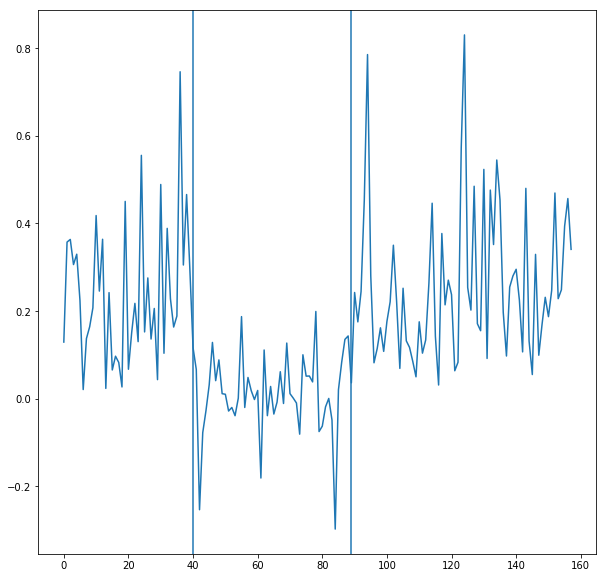

In [56]:
correl_imputed = []
correl_ef = []
for i in range(len(gene_dataset_starmap.gene_names)):
    imputed = np.copy(expected_frequencies_starmap[:, i])
    imputed = imputed/np.sum(expected_frequencies_starmap[:, indexes_to_keep], axis=1)
    imputed = imputed * np.sum(gene_dataset_starmap.X[:, indexes_to_keep], axis=1)
    correl_ef.append(spearmanr(expected_frequencies_starmap[:, i].ravel(), 
                (gene_dataset_starmap.X[:, i]).ravel())[0])
plt.figure(figsize=(10, 10))
x = np.arange(len(gene_dataset_starmap.gene_names))
plt.plot(x, correl_ef)
plt.axvline(x=40)
plt.axvline(x=89)
plt.show()

In [42]:
def get_ordered_correl(idx_gene_key, reference_value):
    correl = [spearmanr(reference_value[:, idx_gene_key].ravel(), expected_frequencies_starmap[:, gene].ravel())[0] 
              for gene in range(158, gene_dataset_seq.X.shape[1])]
    indices = np.argsort(correl) + 158
    return indices

In [43]:
correlated_genes_to_truth = get_ordered_correl(idx_gene_key, gene_dataset_starmap.X)
correlated_genes_to_ef = get_ordered_correl(idx_gene_key, expected_frequencies_starmap)

In [45]:
print(gene_dataset_seq.gene_names[correlated_genes_to_ef[-5:]])
print(gene_dataset_seq.gene_names[correlated_genes_to_truth[-5:]])

['cdk5r1' 'ppp2r2c' 'st3gal5' 'tyro3' 'mef2d']
['pom121' 'adgrb1' 'camsap1' 'cbx6' 'pip5k1a']


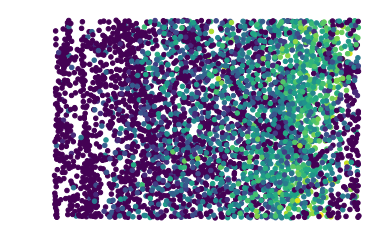

In [46]:
x = gene_dataset_starmap.x_coord
y = gene_dataset_starmap.y_coord
plt.scatter(x, y, c=np.log(1 + gene_dataset_starmap.X[:, idx_gene_key].ravel()), s=20)
plt.axis('off')
plt.show()

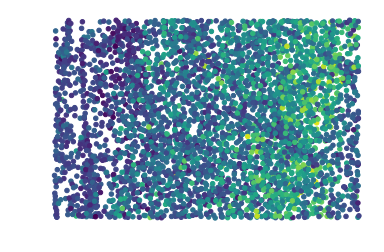

In [48]:
x = gene_dataset_starmap.x_coord
y = gene_dataset_starmap.y_coord
plt.scatter(x, y, c=np.log(1 + expected_frequencies_starmap[:, correlated_genes_to_truth[-1]].ravel()), s=20)
plt.axis('off')
plt.show()

## KNN purity

In [53]:
# Creating the starmap individual analysis
def individual_analysis_starmap():
    dataset_starmap = StarmapDataset(save_path=save_path)
    dataset_starmap.x_coord = None
    dataset_starmap.y_coord = None
    vae = VAE(dataset_starmap.nb_genes, n_batch=3, dispersion="gene-batch", reconstruction_loss="nb")

    trainer = UnsupervisedTrainer(vae, dataset_starmap, train_size=0.9, use_cuda=True)
    trainer.train(n_epochs=100, lr=0.001)
    dic = trainer.get_all_latent_and_imputed_values()
    latent = dic["latent"]
    return latent
latent_individual_starmap = individual_analysis()

training: 100%|██████████| 100/100 [00:31<00:00,  3.15it/s]


In [ ]:
# Creating the scRNA seq individual analysis
def individual_analysis_seq():
    vae = VAE(gene_dataset_seq.nb_genes, dispersion="gene", reconstruction_loss="nb")

    trainer = UnsupervisedTrainer(vae, gene_dataset_seq, train_size=0.9, use_cuda=True)
    trainer.train(n_epochs=100, lr=0.001)
    dic = trainer.get_all_latent_and_imputed_values()
    latent = dic["latent"]
    return latent
latent_individual_seq = individual_analysis_seq()

In [ ]:
from sklearn.neighbors import NearestNeighbors
def JaccardIndex(x1,x2):
    intersection = np.sum(x1*x2)
    union = np.sum((x1+x2)>0)
    return intersection/union



def KNNJaccardIndex(latent,latent_indiv, nn):
    knn = NearestNeighbors(n_neighbors=nn, algorithm='auto')
    nbrs1 = knn.fit(latent)
    nbrs1 = nbrs1.kneighbors_graph(latent).toarray()
    np.fill_diagonal(nbrs1,0)
    nbrs_1 = knn.fit(latent_indiv)
    nbrs_1 = nbrs_1.kneighbors_graph(latent_indiv).toarray()
    np.fill_diagonal(nbrs_1,0)
    JI = [JaccardIndex(x1, x2) for x1, x2 in zip(nbrs1, nbrs_1)]
    return JI

In [ ]:
KNeighbors = np.concatenate([np.arange(10, 100, 10), np.arange(100, 500, 50)])
purity_model_starmap = [KNNJaccardIndex(latent_starmap, latent_individual_starmap, k) 
                for k in KNeighbors]
purity_pca_starmap = [KNNJaccardIndex(pca_latent_starmap, latent_individual_starmap, k) 
                for k in KNeighbors]
purity_mnn_starmap = [KNNJaccardIndex(mnn_latent_starmap, latent_individual_starmap, k) 
                for k in KNeighbors]
purity_scvi_starmap = [KNNJaccardIndex(latent_scvi_starmap, latent_individual_starmap, k) 
                for k in KNeighbors]

In [ ]:
KNeighbors = np.concatenate([np.arange(10, 100, 10), np.arange(100, 500, 50)])
purity_model_seq = [KNNJaccardIndex(latent__seq, latent_individual_seq, k) 
                for k in KNeighbors]
purity_pca_seq = [KNNJaccardIndex(pca_latent_seq, latent_individual_seq, k) 
                for k in KNeighbors]
purity_mnn_seq = [KNNJaccardIndex(mnn_latent_seq, latent_individual_seq, k) 
                for k in KNeighbors]
purity_scvi_seq = [KNNJaccardIndex(latent_scvi_seq, latent_individual_seq, k) 
                for k in KNeighbors]

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(KNeighbors, purity_model_starmap, color='b', label='Our model')
plt.plot(KNeighbors, purity_pca_starmap, color='r', label='Normalized PCA')
plt.plot(KNeighbors, purity_mnn_starmap, color='y', label='MNN')
plt.plot(KNeighbors, purity_scvi_starmap, color='g', label='scVI')
plt.xlabel("Number of neighbors used")
plt.ylabel("Jaccard index")
plt.legend()
plt.title('KNN purity on latent space of STARmap cells')

plt.subplot(1, 2, 2)
plt.plot(KNeighbors, purity_model_seq, color='b', label='Our model')
plt.plot(KNeighbors, purity_pca_seq, color='r', label='Normalized PCA')
plt.plot(KNeighbors, purity_mnn_seq, color='y', label='MNN')
plt.plot(KNeighbors, purity_scvi_seq, color='g', label='scVI')
plt.xlabel("Number of neighbors used")
plt.ylabel("Jaccard index")
plt.legend()
plt.title('KNN purity on latent space of Dropseq cells')

plt.show()
#plt.savefig('/home/jules/fish/knn_purity_plot.pdf')

# 3. Imputation

In [14]:
def get_index(gene_names, gene):
    idx = 0
    for gene_cortex in range(len(gene_names)):
        if gene_names[gene_cortex].lower() == gene.lower():
            idx = gene_cortex
            print("Found idx " + str(idx) + " for gene " + gene + "!")
    return idx

idx_genes_imputed = [get_index(gene_dataset_seq.gene_names, gene) for gene in genes_discarded]
#idx_scvi_genes_imputed = [get_index(scvi_dataset_genes, gene) for gene in genes_discarded]

Found idx 0 for gene acss1!
Found idx 1 for gene adcyap1!
Found idx 2 for gene adgrl2!
Found idx 3 for gene aqp4!
Found idx 4 for gene arc!
Found idx 5 for gene arf5!
Found idx 6 for gene arhgap24!
Found idx 7 for gene arl4d!
Found idx 8 for gene arx!
Found idx 9 for gene batf3!
Found idx 10 for gene bcl6!
Found idx 11 for gene bdnf!
Found idx 12 for gene bgn!
Found idx 13 for gene btg2!
Found idx 14 for gene calb2!
Found idx 15 for gene car12!
Found idx 16 for gene car4!
Found idx 17 for gene cbln4!
Found idx 18 for gene cck!
Found idx 19 for gene cdh13!
Found idx 20 for gene cdk6!
Found idx 21 for gene chat!
Found idx 22 for gene chodl!
Found idx 23 for gene chrna6!
Found idx 24 for gene col6a1!
Found idx 25 for gene cplx3!
Found idx 26 for gene cpne5!
Found idx 27 for gene crh!
Found idx 28 for gene crispld2!
Found idx 29 for gene csrnp1!
Found idx 30 for gene ctgf!
Found idx 31 for gene ctxn3!
Found idx 32 for gene cux2!
Found idx 33 for gene cxcl14!
Found idx 34 for gene ddit4l!
F

## Imputing the value for a missing gene: our method vs baselines

In [15]:
def imputation_metrics(original, imputed):
    absolute_error = np.abs(original - imputed)
    relative_error = absolute_error / np.maximum(np.abs(original), np.ones_like(original))
    spearman = 0
    if np.mean(imputed == 0) < 1:
        spearman = spearmanr(original, imputed)[0]
    return {"mean_absolute_error": np.mean(absolute_error), "median_absolute_error": np.median(absolute_error), 
            "mean_relative_error": np.mean(relative_error), "median_relative_error": np.median(relative_error), 
            "spearman": spearman}

In [16]:
imputed = np.copy(expected_frequencies_starmap[:, idx_genes_imputed])
imputed /= np.sum(expected_frequencies_starmap[:, vae.indexes_to_keep], axis=1).ravel()[:, np.newaxis]
imputed *= np.sum(gene_dataset_starmap.X[:, vae.indexes_to_keep], axis=1)[:, np.newaxis]


pca_imputed = []
for t, idx_gene1 in enumerate(idx_genes_imputed):
    predicted_PCA = proximity_imputation(PCA_latent_seq, gene_dataset_seq.X[:, idx_gene1], PCA_latent_starmap, k=5)
    pca_imputed.append(predicted_PCA)
pca_imputed = np.array(pca_imputed).T
print(pca_imputed.shape)


mnn_imputed = []
for t, idx_gene1 in enumerate(idx_genes_imputed):
    predicted_mnn = proximity_imputation(mnn_latent_seq, gene_dataset_seq.X[:, idx_gene1], mnn_latent_starmap, k=5)
    mnn_imputed.append(predicted_mnn)
mnn_imputed = np.array(mnn_imputed).T
print(mnn_imputed.shape)

scvi_imputed = []
for t, idx_gene1 in enumerate(idx_genes_imputed):
    predicted_scvi = proximity_imputation(latent_scvi_seq, gene_dataset_seq.X[:, idx_gene1], latent_scvi_starmap, k=5)
    scvi_imputed.append(predicted_scvi)
scvi_imputed = np.array(scvi_imputed).T
print(scvi_imputed.shape)

ground_truth = np.log(1 + gene_dataset_starmap.X)

(3702, 50)
(3702, 50)
(3702, 50)


## Spatial imputation

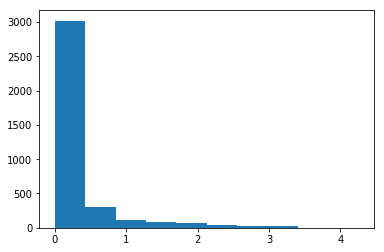

egr1


In [265]:
plt.hist(np.log(1 + imputed[:, idx_genes_imputed[49]]).ravel())
plt.show()
print(gene_names[36])

In [ ]:
pas mal: 2, 4+, 5, 12, avec ordre, 13-, 16, 18+, 34-, 35, 38-, 40
bon: 7, 24-, 25 avec ordre, 32, 36 maos tout le monde, 43-, 46, 49 avec ordre
ground est bien mais pas model; 3, 8, 19, 30

In [1]:
gene_of_interest = idx_genes_imputed[3]
print(gene_dataset_starmap.gene_names[4])
x = gene_dataset_starmap.x_coord
y = gene_dataset_starmap.y_coord
plt.scatter(x, y, c=ground_truth[:, gene_of_interest].ravel(), s=20)
plt.show()

NameError: name 'idx_genes_imputed' is not defined

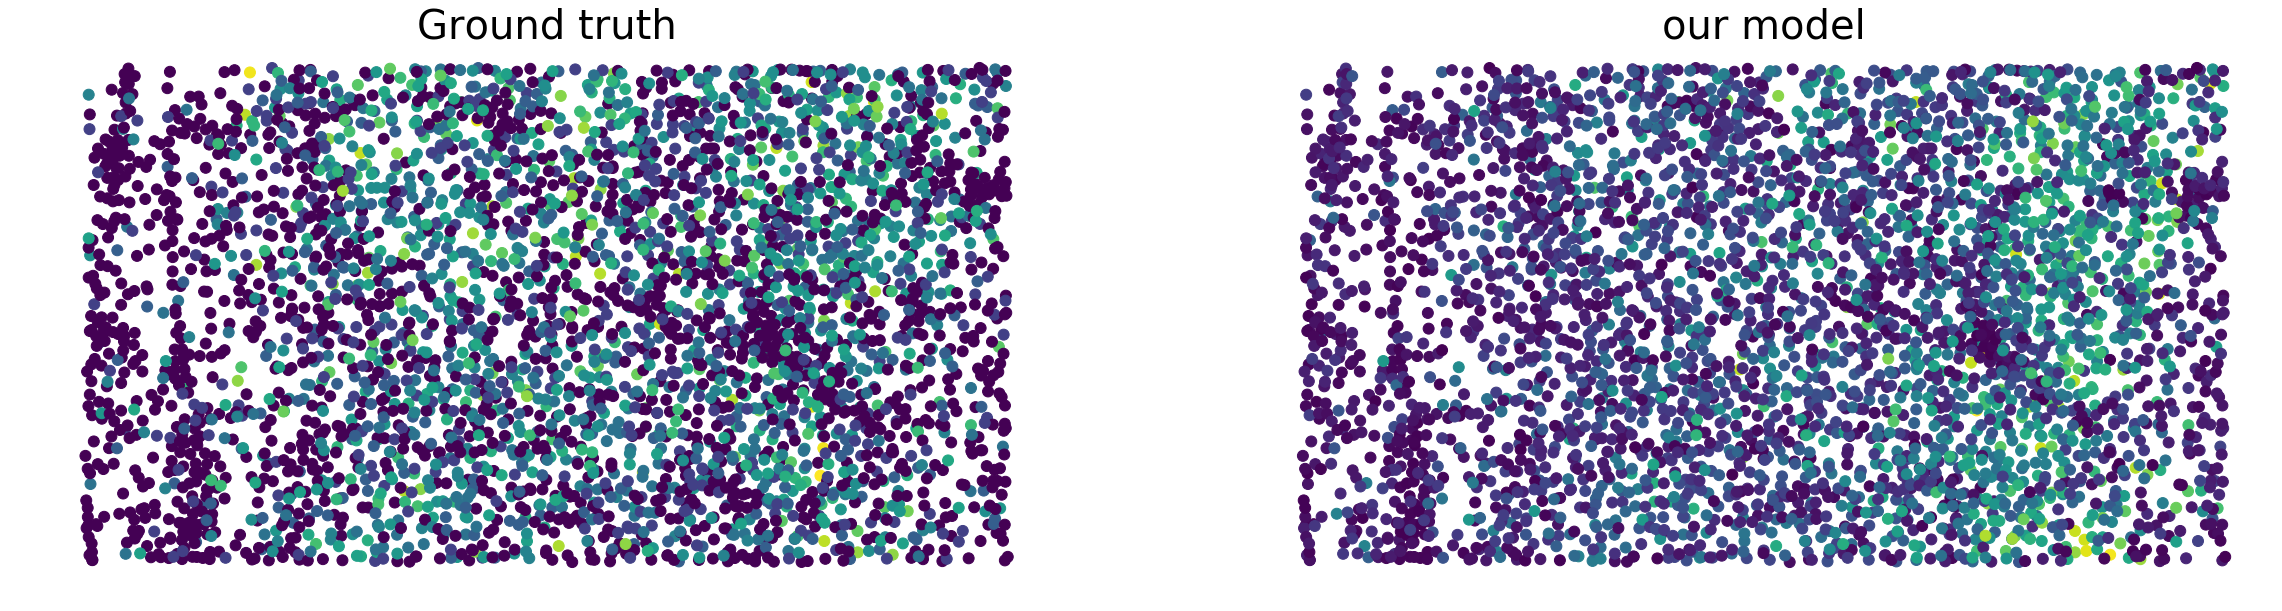

In [304]:
x = gene_dataset_starmap.x_coord
y = gene_dataset_starmap.y_coord
plt.figure(figsize=(40, 10))
plt.subplot(1, 2, 1)
plt.scatter(x, y, c=ground_truth[:, gene_of_interest].ravel(), s=120)
plt.axis('off')
plt.title("Ground truth", fontsize=40)
plt.subplot(1, 2, 2)
plt.scatter(x, y, c=np.log(1 + imputed[:, gene_of_interest]).ravel(), s=120)
plt.axis('off')

plt.title("our model", fontsize=40)
plt.show()
#plt.savefig("/home/jules/starmap/truth_versus_model_fam19a1.pdf")


#haut = (np.log(1 + imputed[:, gene_of_interest]) >= 0.1).ravel()
#bas = (np.log(1 + imputed[:, gene_of_interest]) < 0.1).ravel()
#plt.scatter(x[bas], y[bas], c=np.log(1 + imputed[bas, gene_of_interest]).ravel(), s=120)
#plt.scatter(x[haut], y[haut], c=np.log(1 + imputed[haut, gene_of_interest]).ravel(), s=120)

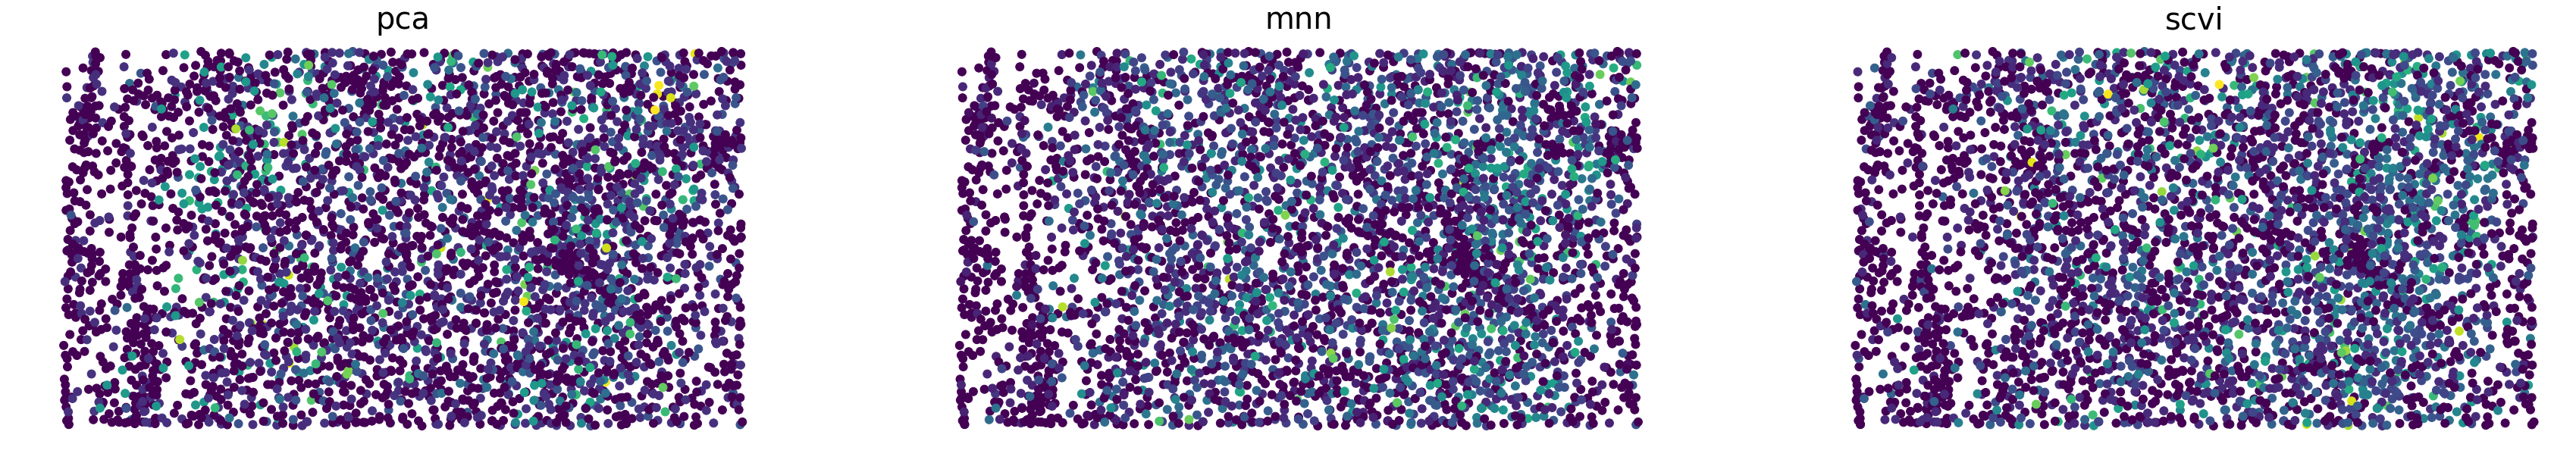

In [306]:
plt.figure(figsize=(60, 10))
plt.subplot(1, 3, 1)
plt.scatter(x, y, c=np.log(1+ pca_imputed[:, gene_of_interest]).ravel(), s=120)
plt.axis('off')
plt.title("pca", fontsize=40)
plt.subplot(1, 3, 2)
plt.scatter(x, y, c=np.log(1 + mnn_imputed[:, gene_of_interest]).ravel(), s=120)
plt.axis('off')
plt.title("mnn", fontsize=40)
plt.subplot(1, 3, 3)
plt.scatter(x, y, c=np.log(1+ scvi_imputed[:, gene_of_interest]).ravel(), s=120)
plt.axis('off')
plt.title('scvi', fontsize=40)
#plt.show()
plt.savefig("/home/jules/starmap/baselines_arc.pdf")

## Measuring imputation errors

In [22]:

model_med_abs = np.median(model_med_abs, axis=0).reshape(5, 50)

model_spearman = np.median(model_spearman, axis=0)


pca_med_abs = []
for t, idx_gene1 in enumerate(idx_genes_imputed):
    predicted_PCA = proximity_imputation(PCA_latent_seq, gene_dataset_seq.X[:, idx_gene1], PCA_latent_starmap, k=5)
    pca_med_abs.append(imputation_metrics(gene_dataset_starmap.X[:, idx_gene1], predicted_PCA)["median_absolute_error"])
pca_med_abs = np.array(pca_med_abs)

mnn_med_abs = []
for t, idx_gene1 in enumerate(idx_genes_imputed):
    predicted_mnn = proximity_imputation(mnn_latent_seq, gene_dataset_seq.X[:, idx_gene1], mnn_latent_starmap, k=5)
    mnn_med_abs.append(imputation_metrics(gene_dataset_starmap.X[:, idx_gene1], predicted_mnn)["median_absolute_error"])
mnn_med_abs = np.array(mnn_med_abs)


KeyboardInterrupt: 

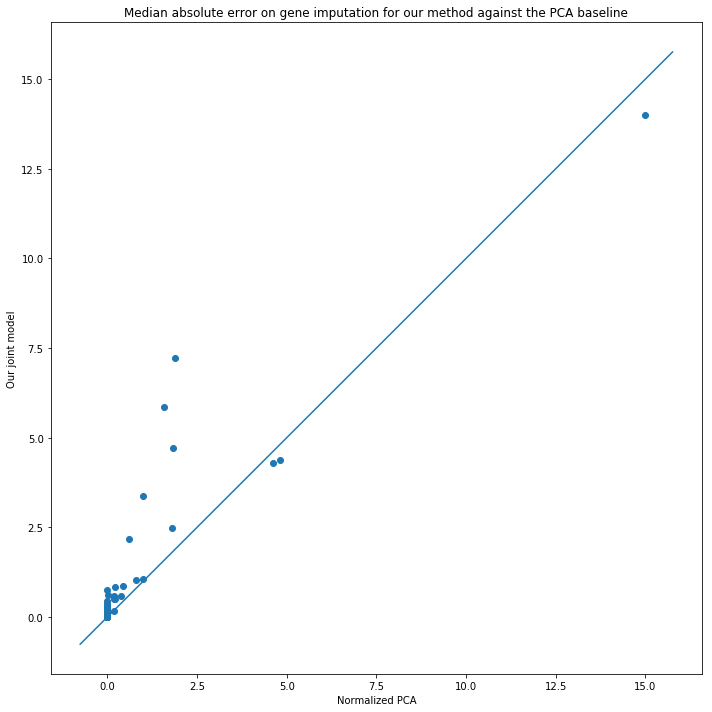

In [31]:
plt.figure(figsize=(10, 10))
plt.scatter(pca_med_abs, model_med_abs)
plt.xlabel("Normalized PCA")
plt.ylabel("Our joint model")
x = np.linspace(*plt.xlim())
plt.plot(x, x)
plt.title('Median absolute error on gene imputation for our method against the PCA baseline')
plt.tight_layout()
plt.savefig('/home/jules/Median_absolute_error_versus_pca.pdf')

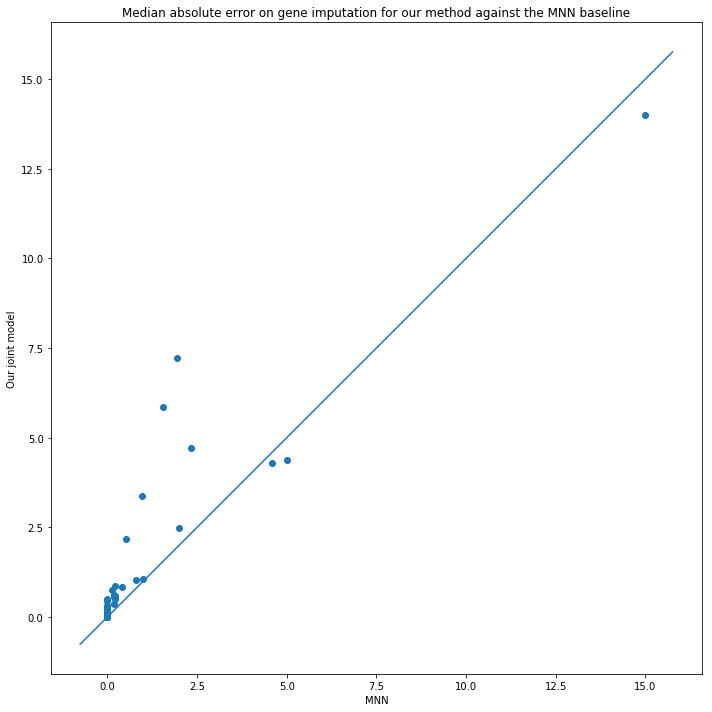

In [32]:
plt.figure(figsize=(10, 10))
plt.scatter(mnn_med_abs, model_med_abs)
plt.xlabel("MNN")
plt.ylabel("Our joint model")
x = np.linspace(*plt.xlim())
plt.plot(x, x)
plt.title('Median absolute error on gene imputation for our method against the MNN baseline')
plt.tight_layout()
plt.savefig('/home/jules/Median_absolute_error_versus_mnn.pdf')

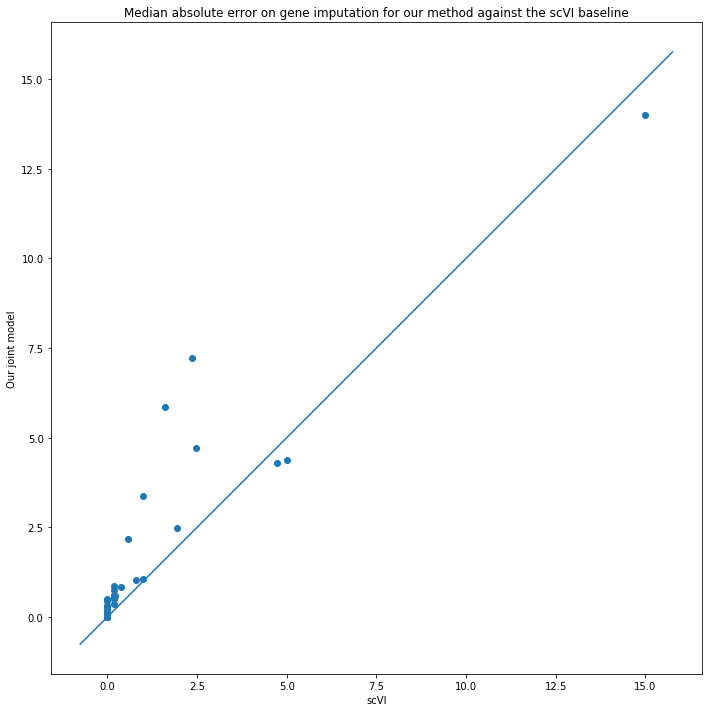

In [33]:
plt.figure(figsize=(10, 10))
plt.scatter(scvi_med_abs, model_med_abs)
plt.xlabel("scVI")
plt.ylabel("Our joint model")
x = np.linspace(*plt.xlim())
plt.plot(x, x)
plt.title('Median absolute error on gene imputation for our method against the scVI baseline')
plt.tight_layout()
plt.savefig('/home/jules/Median_absolute_error_versus_scvi.pdf')

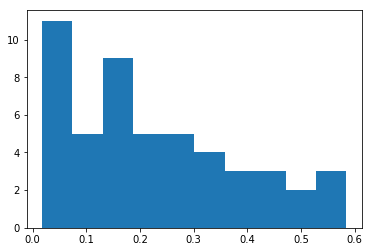

(0.18772467431676693, 0.2311649742814289)

In [16]:
imputed = expected_frequencies_starmap[:, idx_genes_imputed]
imputed /= np.sum(expected_frequencies_starmap[:, vae.indexes_to_keep], axis=1).ravel()[:, np.newaxis]
imputed *= np.sum(gene_dataset_starmap.X[:, vae.indexes_to_keep], axis=1)[:, np.newaxis]
l = np.array([imputation_metrics(gene_dataset_starmap.X[:, idx_gene1], imputed[:, t])["spearman"] 
          for t, idx_gene1 in enumerate(idx_genes_imputed)])
plt.hist(l) 
plt.show()
np.median(l), np.mean(l)

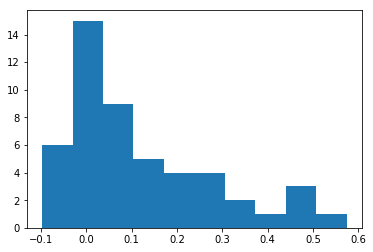

(0.04051647921754563, 0.11717457862092491)

In [17]:
l = []
for t, idx_gene1 in enumerate(idx_genes_imputed):
    predicted_PCA = proximity_imputation(PCA_latent_seq, gene_dataset_seq.X[:, idx_gene1], PCA_latent_starmap, k=5)
    l.append(imputation_metrics(gene_dataset_starmap.X[:, idx_gene1], predicted_PCA)["spearman"])
l = np.array(l)
plt.hist(l) 
plt.show()
np.median(l), np.mean(l)

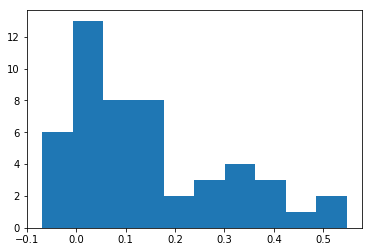

(0.10679447805577738, 0.14179592161603774)

In [18]:
l = []
for t, idx_gene1 in enumerate(idx_genes_imputed):
    predicted_mnn = proximity_imputation(mnn_latent_seq, gene_dataset_seq.X[:, idx_gene1], mnn_latent_starmap, k=5)
    l.append(imputation_metrics(gene_dataset_starmap.X[:, idx_gene1], predicted_mnn)["spearman"])
l = np.array(l)
plt.hist(l) 
plt.show()
np.median(l), np.mean(l)

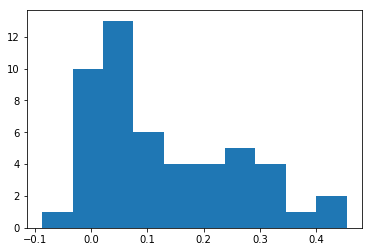

(0.07625070089416257, 0.126826030182668)

In [19]:
l = []
for t, idx_gene1 in enumerate(idx_genes_imputed):
    predicted_scvi = proximity_imputation(latent_scvi_seq, gene_dataset_seq.X[:, idx_gene1], latent_scvi_starmap, k=5)
    l.append(imputation_metrics(gene_dataset_starmap.X[:, idx_gene1], predicted_scvi)["spearman"])
l = np.array(l)
plt.hist(l) 
plt.show()
np.median(l), np.mean(l)

In [20]:
# here we also use our model's latent reprensentation of the cells but rather than using the output 
# of the generative model in order to impute the missing values for the starmap cells we use a knn approach on the 
# latent space, just like the baselines
# predicted = proximity_imputation(latent_seq, gene_dataset_seq.X[:, idx_gene1], latent_starmap, k=5)
# plot_imputation(np.log(1 + predicted), np.log(1 + gene_dataset_starmap.X[:, idx_gene1]))
# print(imputation_metrics(gene_dataset_starmap.X[:, idx_gene1], predicted))

# 4. Getting a common meaningful representation

In [60]:
def get_common_umap(latent_seq, latent_fish):
    full_latent = np.concatenate((latent_seq, latent_fish))
    if full_latent.shape[1] != 2:
        latent =  TSNE().fit_transform(full_latent)
    return latent[:latent_seq.shape[0], :], latent[latent_seq.shape[0]:, :]

t_sne_seq, t_sne_starmap = get_common_umap(latent_seq, latent_starmap)
t_sne_PCA_seq, t_sne_PCA_starmap = get_common_umap(PCA_latent_seq, PCA_latent_starmap)
t_sne_mnn_seq, t_sne_mnn_starmap = get_common_umap(mnn_latent_seq, mnn_latent_starmap)
t_sne_scvi_seq, t_sne_scvi_starmap = get_common_umap(latent_scvi_seq, latent_scvi_starmap)

In [78]:
batch_indices = np.concatenate(
    (np.zeros(gene_dataset_starmap.X.shape[0]), np.ones(gene_dataset_seq.X.shape[0])))

In [91]:
latent = np.concatenate((t_sne_mnn_starmap, t_sne_mnn_seq), axis=0)

## Our method: Embedding of the two datasets in the shared latent space

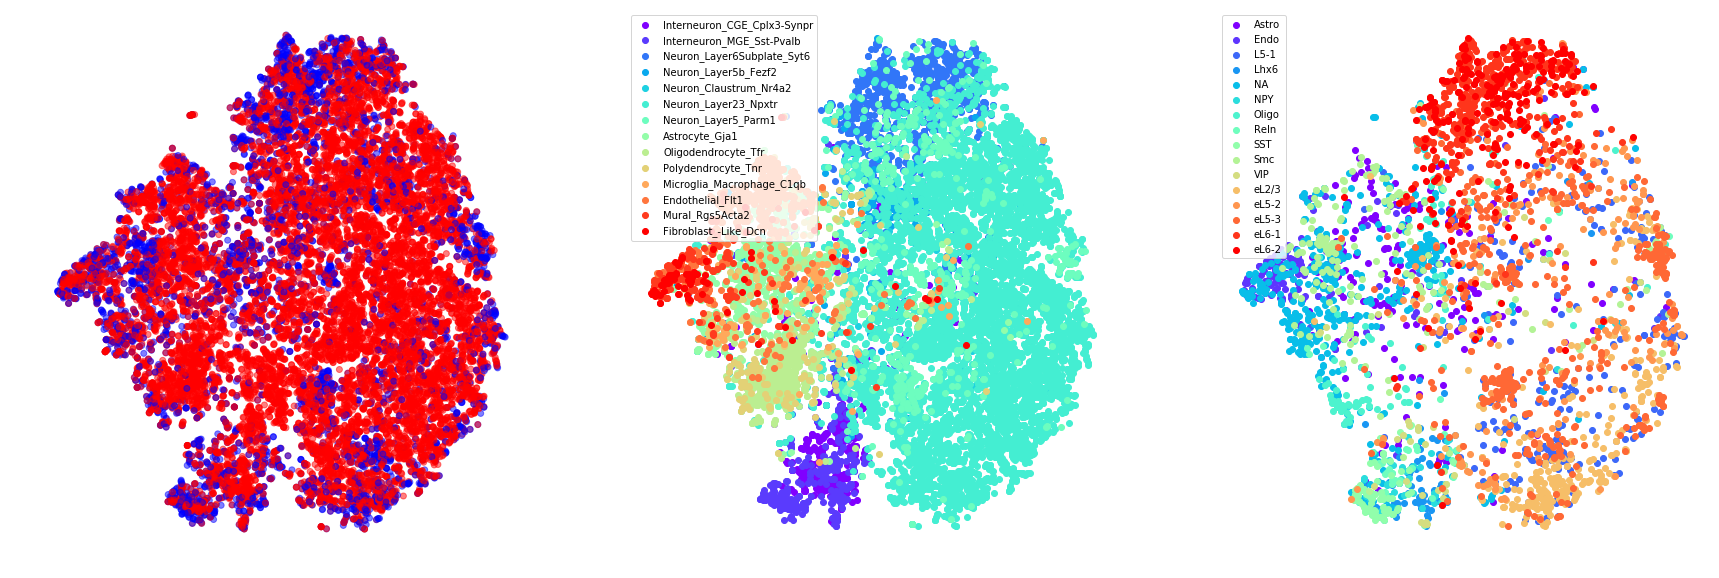

In [93]:
import matplotlib.cm as cm
flip_idx = np.random.permutation(np.arange(latent.shape[0]))
plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.axis("off")
plt.scatter(latent[flip_idx, 0], latent[flip_idx, 1], c=batch_indices[flip_idx], cmap=plt.get_cmap('bwr'), alpha=0.5)
plt.subplot(1, 3, 2)
plt.axis("off")
colors = cm.rainbow(np.linspace(0, 1, 14))
for i, c in zip(np.unique(gene_dataset_seq.labels.ravel()), colors):
    plt.scatter(t_sne_mnn_seq[gene_dataset_seq.labels.ravel() == i, 0], 
                t_sne_mnn_seq[gene_dataset_seq.labels.ravel() == i, 1], color=c, label=gene_dataset_seq.cell_types[i])
plt.legend(loc='upper left')
plt.subplot(1, 3, 3)
plt.axis("off")
colors = cm.rainbow(np.linspace(0, 1, 16))
for i, c in zip(np.unique(gene_dataset_starmap.labels.ravel()), colors):
    plt.scatter(t_sne_mnn_starmap[gene_dataset_starmap.labels.ravel() == i, 0], 
                t_sne_mnn_starmap[gene_dataset_starmap.labels.ravel() == i, 1], color=c, label=gene_dataset_starmap.cell_types[i])
plt.legend(loc='upper left')
plt.savefig('/home/jules/starmap/latent_embedding_MNN.pdf')
#plt.show()



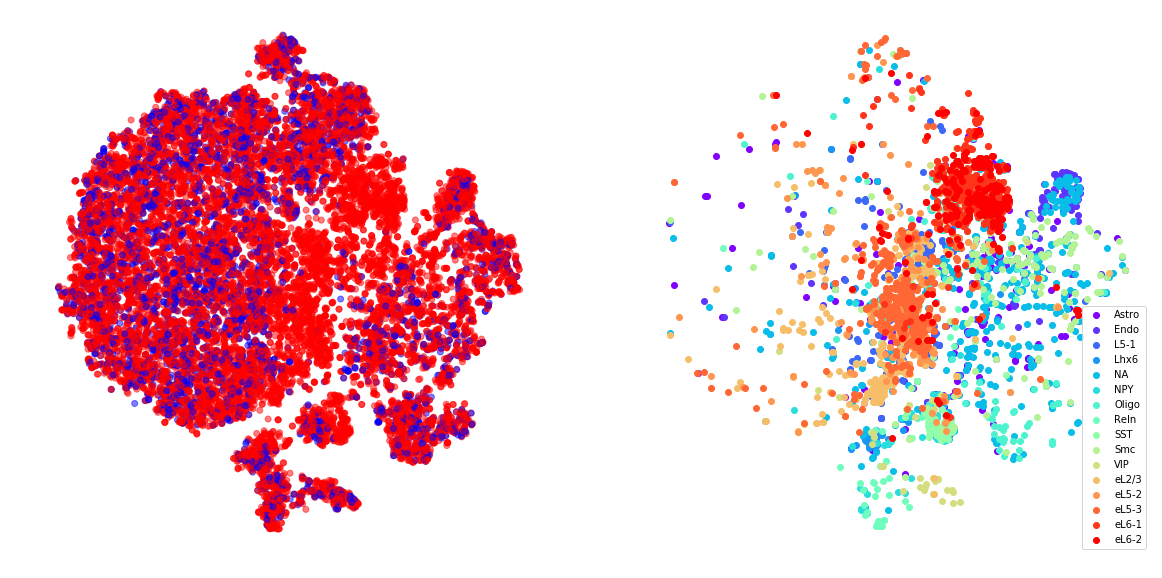

In [69]:
import matplotlib.cm as cm
latent = np.concatenate((t_sne_seq, t_sne_starmap), axis=0)
flip_idx = np.random.permutation(np.arange(latent.shape[0]))
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.scatter(latent[flip_idx, 0], latent[flip_idx, 1], c=batch_indices[flip_idx], cmap=plt.get_cmap('bwr'), alpha=0.5)
plt.subplot(1, 2, 2)
plt.axis("off")
colors = cm.rainbow(np.linspace(0, 1, 16))
for i, c in zip(np.unique(gene_dataset_starmap.labels.ravel()), colors):
    plt.scatter(t_sne_starmap[gene_dataset_starmap.labels.ravel() == i, 0], 
                t_sne_starmap[gene_dataset_starmap.labels.ravel() == i, 1], color=c, label=gene_dataset_starmap.cell_types[i])
plt.legend()
plt.show()

In [73]:
print("show for each dataset the repartition in different cell_types")
print("Starmap repartition")
labels_of_starmap = np.unique(gene_dataset_starmap.labels.ravel(), return_counts=True)
for i in range(16):
    print(gene_dataset_starmap.cell_types[i]+ " , " + str(labels_of_starmap[1][i]) + " cells")
print("Dropseq repartition")
labels_of_seq = np.unique(gene_dataset_seq.labels.ravel(), return_counts=True)
for i in range(14):
    print(gene_dataset_seq.cell_types[i]+ " , " + str(labels_of_seq[1][i]) + " cells")

show for each dataset the repartition in different cell_types
Starmap repartition
Astro , 240 cells
Endo , 172 cells
L5-1 , 306 cells
Lhx6 , 95 cells
NA , 524 cells
NPY , 53 cells
Oligo , 118 cells
Reln , 49 cells
SST , 84 cells
Smc , 191 cells
VIP , 44 cells
eL2/3 , 329 cells
eL5-2 , 226 cells
eL5-3 , 496 cells
eL6-1 , 516 cells
eL6-2 , 259 cells
Dropseq repartition
Interneuron_CGE_Cplx3-Synpr , 599 cells
Interneuron_MGE_Sst-Pvalb , 478 cells
Neuron_Layer6Subplate_Syt6 , 1423 cells
Neuron_Layer5b_Fezf2 , 320 cells
Neuron_Claustrum_Nr4a2 , 93 cells
Neuron_Layer23_Npxtr , 8229 cells
Neuron_Layer5_Parm1 , 537 cells
Astrocyte_Gja1 , 906 cells
Oligodendrocyte_Tfr , 847 cells
Polydendrocyte_Tnr , 228 cells
Microglia_Macrophage_C1qb , 143 cells
Endothelial_Flt1 , 737 cells
Mural_Rgs5Acta2 , 217 cells
Fibroblast_-Like_Dcn , 88 cells


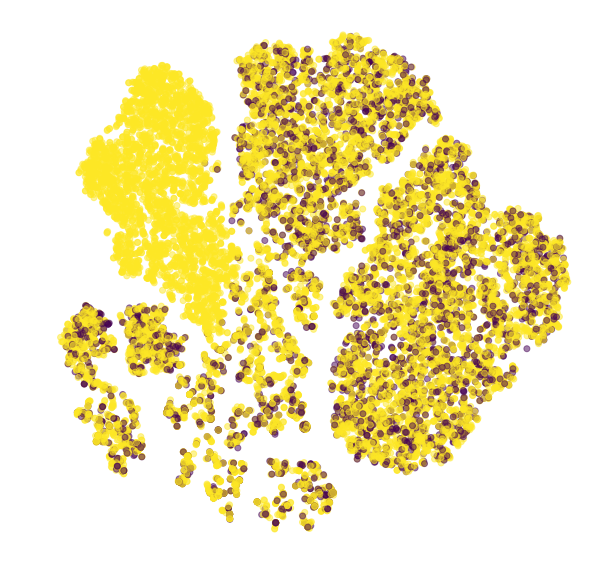

In [49]:
latent = np.concatenate((t_sne_PCA_seq, t_sne_PCA_starmap), axis=0)
flip_idx = np.random.permutation(np.arange(latent.shape[0]))
# trainer.train_seq.show_t_sne(None, color_by = 'batches', 
#                              latent = latent, 
#                              batch_indices = batch_indices, n_batch=2)
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.scatter(latent[flip_idx, 0], latent[flip_idx, 1], c=batch_indices[flip_idx], alpha=0.5)
plt.show()

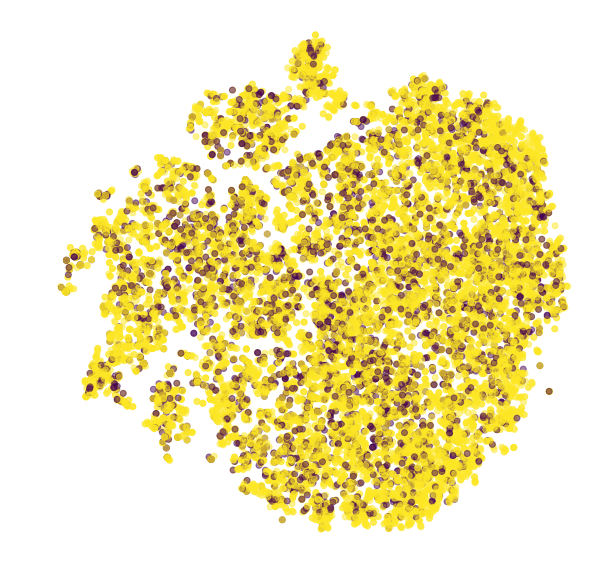

In [50]:
latent = np.concatenate((t_sne_mnn_seq, t_sne_mnn_starmap), axis=0)
flip_idx = np.random.permutation(np.arange(latent.shape[0]))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.scatter(latent[flip_idx, 0], latent[flip_idx, 1], c=batch_indices[flip_idx], alpha=0.5)
plt.show()

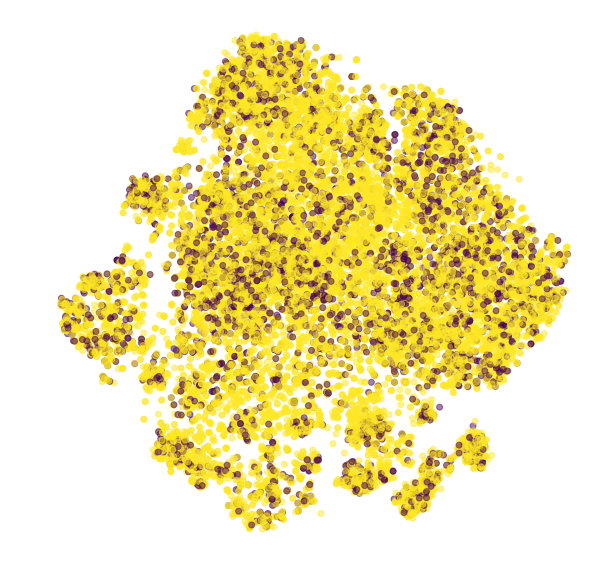

In [51]:
latent = np.concatenate((t_sne_scvi_seq, t_sne_scvi_starmap), axis=0)
flip_idx = np.random.permutation(np.arange(latent.shape[0]))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.scatter(latent[flip_idx, 0], latent[flip_idx, 1], c=batch_indices[flip_idx], alpha=0.5)
plt.show()

## Batch entropy: How well do the datasets mix in the latent space?

In [52]:
entropy_batch_mixing(np.concatenate((latent_seq, latent_starmap)),
                           batches=np.concatenate((np.zeros(latent_seq.shape[0]),
                                                  np.ones(latent_starmap.shape[0]))))

0.19576769861579948

In [53]:
entropy_batch_mixing(np.concatenate((PCA_latent_seq, PCA_latent_starmap)),
                               batches=np.concatenate((np.zeros(latent_seq.shape[0]),
                                                  np.ones(latent_starmap.shape[0]))))

0.14984548758166877

In [54]:
entropy_batch_mixing(np.concatenate((mnn_latent_seq, mnn_latent_starmap)),
                               batches=np.concatenate((np.zeros(latent_seq.shape[0]),
                                                  np.ones(latent_starmap.shape[0]))))

0.2873854770819139

In [55]:
entropy_batch_mixing(np.concatenate((latent_scvi_seq, latent_scvi_starmap)),
                               batches=np.concatenate((np.zeros(latent_scvi_seq.shape[0]),
                                                  np.ones(latent_scvi_starmap.shape[0]))))

0.4774049592975336

In [56]:
def allow_notebook_for_test():
    print("Testing the scRNA and starMAP notebook")
    
# don't mind this, it is used only when the travis build tests the notebooks